## Experiment 2a: Comparative Analysis of XAI Methods (`MNIST`)

**Selected Methods**
- Vanilla Gradients (Saliency)
- Integrated Gradients (IG)
- GradientSHAP

In [217]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import softmax
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import quantus
from captum.attr import Saliency, IntegratedGradients, GradientShap

In [219]:
# Reproducibility
np.random.seed(42); torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Load `MNIST` Dataset

In [221]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

data_root = pathlib.Path('./data')
mnist_train = datasets.MNIST(data_root, train=True, download=True, transform=transform)
mnist_test  = datasets.MNIST(data_root, train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
test_loader  = DataLoader(mnist_test,  batch_size=256, shuffle=False)

### CNN Model

In [222]:
class CNN(nn.Module):
    """A CNN for MNIST digit classification.
    Architecture: 2 conv layers, max pooling, dropout, and 2 FC layers.
    """
    def __init__(self, dropout1=0.25, dropout2=0.5):
        """Initialize the CNN model."""
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3), nn.ReLU(),
            nn.Conv2d(32, 64, 3), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout2d(dropout1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 12 * 12, 128), nn.ReLU(),
            nn.Dropout(dropout2), 
            nn.Linear(128, 10),
            #nn.Softmax(dim=1)
        )

    def forward(self, x):
        """Forward pass of the model."""
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [223]:
def train_or_load(model: nn.Module, ckpt: pathlib.Path, loader: DataLoader, epochs=5):
    """Train a model or load from checkpoint if it exists."""
    # If checkpoint exists, load the saved weights and return model
    if ckpt.exists():
        model.load_state_dict(torch.load(ckpt, map_location=device))
        print(f"Loaded cached weights from {ckpt}.")
        return model

    # Set up training
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    model.train()
    
    # Training loop
    for epoch in range(1, epochs+1):
        total_loss = 0.0
        correct, total = 0, 0
        # Batch loop
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(imgs)  # Get model predictions
            loss = criterion(outputs, labels)  # Calculate loss
            
            # Backward pass
            loss.backward()  # Compute gradients
            optimizer.step() # Update weights
            
            # Track metrics
            total_loss += loss.item()  
            pred = outputs.argmax(dim=1)  # Get predicted classes
            correct += (pred == labels).sum().item()  
            total += labels.size(0)
            
        # Calculate epoch metrics
        avg_loss = total_loss/len(loader)  # Average loss per batch
        acc = correct/total*100  # Accuracy as percentage
        print(f"Epoch {epoch}: loss={avg_loss:.3f}, acc={acc:.1f}%")
    # Save the trained model
    torch.save(model.state_dict(), ckpt)
    print(f"Model saved to {ckpt}.")
    return model

In [224]:
# Load the trained CNN model
CKPT_PATH = pathlib.Path('models/ex2_mnist_cnn.pth')

model = CNN().to(device)
model = train_or_load(model, CKPT_PATH, train_loader)

Loaded cached weights from ex2_mnist_cnn.pth.


In [225]:
# Evaluate
model.eval()
with torch.no_grad():
    total, correct = 0, 0
    for imgs, labels in test_loader:
        outputs = model(imgs.to(device))
        pred = outputs.argmax(dim=1).cpu()
        correct += (pred == labels).sum().item()
        total += labels.size(0)
print(f"Test accuracy: {correct/total*100:.2f}%")

Test accuracy: 98.98%


In [ ]:
# ----------------------- Helpers -----------------------
def normalize_attr(attr: torch.Tensor):
    """Normalize attribution scores to [-1,1] range using max absolute value."""
    arr = attr.cpu().numpy()
    max_val = np.abs(arr).max()
    return arr / max_val if max_val > 0 else arr

def normalize_attr_L1(attr: torch.Tensor):
    """Normalize attribution scores using L1 norm."""
    arr = attr.cpu().abs().numpy().flatten()
    s = arr.sum()
    return arr/s if s>0 else arr

def overlay(ax, img: np.ndarray, attr: np.ndarray=None, vmin: float=-1, vmax: float=1):
    """Plot image with optional attribution overlay."""
    ax.imshow(img.squeeze(), cmap='gray_r')
    if attr is not None:
        ax.imshow(attr.squeeze(), cmap='seismic', vmin=vmin, vmax=vmax, alpha=0.8)
    ax.axis('off')

In [234]:
def compute_attribution(method: str, model: nn.Module, x: torch.Tensor, target: int, steps=50):
    """Compute attribution scores using various XAI methods."""
    # Ensure evaluation mode
    model.eval()

    if method == 'vanilla': # Custom Vanilla Gradients
        x = x.clone().detach().requires_grad_(True)
        model.zero_grad(set_to_none=True)
        logits = model(x)[:, target] # (B,) tensor
        logits.backward(torch.ones_like(logits))
        #model.zero_grad(set_to_none=True)
        return x.grad.detach()

    elif method == 'ig': # Integrated Gradients
        baseline = torch.zeros_like(x)
        #baseline = torch.randn_like(x).mul_(0.001) 
        model.zero_grad(set_to_none=True)
        ig = IntegratedGradients(model) 
        return ig.attribute(x, baselines=baseline, target=target, n_steps=steps).detach()

    elif method == 'shap': # GradientSHAP
        gs = GradientShap(model)
        # small noise around zero-baseline (50 samples)
        baselines = torch.randn(50, *x.shape[1:], device=x.device).mul_(0.001)
        return gs.attribute(x, baselines=baselines, target=target).detach()

    model.zero_grad(set_to_none=True)
    x.grad = None
    raise ValueError(f"Unknown method {method}")

### Panel A: Single-sample Comparison
- qualitative assessment of the selected XAI attribution methods on a single MNIST sample
  - Vanilla Gradients (Saliency)
  - Integrated Gradients
  - GradientSHAP

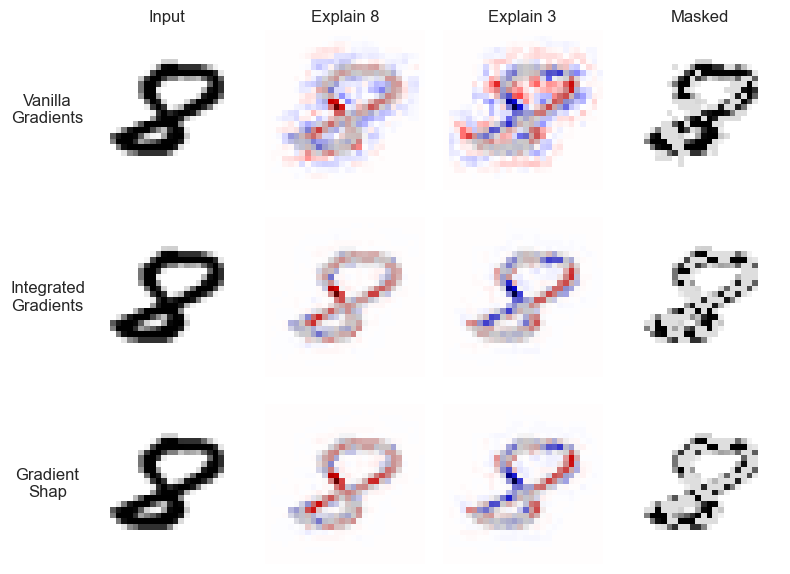

In [227]:
REMOVE_P = 0.1
methods = ["vanilla", "ig", "shap"]
n_methods = len(methods)

labels  = ["Vanilla\nGradients", "Integrated\nGradients", "Gradient\nShap"]
col_titles = ["Input", "Explain 8", "Explain 3", "Masked"]

# select a single true '8'
batch_imgs, batch_tgts = next(iter(test_loader))
idx8 = (batch_tgts == 8).nonzero(as_tuple=True)[0][0]
vis_img = batch_imgs[idx8:idx8+1].to(device)

# compute attributions and plot
fig, axs = plt.subplots(n_methods, 4, figsize=(8, 6), sharex=True, sharey=True)
for ax, title in zip(axs[0], col_titles):
    ax.set_title(title, fontsize=12)
for row, (method, label) in enumerate(zip(methods, labels)):
    # attributions
    a8 = compute_attribution(method, model, vis_img, target=8)
    a3 = compute_attribution(method, model, vis_img, target=3)
    na8, na3 = normalize_attr(a8), normalize_attr(a3)
    # mask top pixels
    k = int(REMOVE_P * 28 * 28)
    idxk = torch.topk(a8.abs().view(-1), k).indices.cpu()
    masked = vis_img.clone().cpu().view(-1)
    masked[idxk] = 0
    masked = masked.view(1,1,28,28)
    # plotting
    overlay(axs[row,0], vis_img.cpu().numpy())
    overlay(axs[row,1], vis_img.cpu().numpy(), na8)
    overlay(axs[row,2], vis_img.cpu().numpy(), na3)
    overlay(axs[row,3], masked.numpy())
    axs[row,0].text(-0.25, 0.5, label, transform=axs[row,0].transAxes, fontsize=12, va='center', ha='center')
plt.tight_layout()
plt.show()

### Panel B: Attribution Impact Distribution
- evaluate the *impact* of different attribution methods on MNIST digit classification:
  - `log-odds` to measure classification confidence

For each image and attribution methods:
- get model's base prediction and confidence
- compute attributions for the predicted class
- mask the top K most important pixels (based on attribution values)
- measure drop in prediction confidence after masking

In [ ]:
def log_odds(p, eps=1e-7):
    """Computes log odds ratio log(p/(1-p)) with numerical stability."""
    p = np.clip(p, eps, 1-eps)
    return np.log(p / (1-p))

N_TEST    = 256
REMOVE_K  = int(REMOVE_P * 28 * 28)
rng       = torch.Generator().manual_seed(0)

# 1. collect exactly N_TEST images
imgs_accum = []
for imgs, _ in test_loader:
    imgs_accum.append(imgs)
    if sum(x.shape[0] for x in imgs_accum) >= N_TEST:
        break
all_imgs = torch.cat(imgs_accum)[:N_TEST]

# 2. shuffle subset
perm      = torch.randperm(len(all_imgs), generator=rng)
eval_imgs = all_imgs[perm]

In [ ]:
results = {label: [] for label in labels}
model.eval()

for img in eval_imgs:
    img = img.unsqueeze(0).to(device)

    # 3. compute base log-odds
    with torch.no_grad():
        logits    = model(img)
        probs     = softmax(logits, dim=1)
        pred_idx  = int(probs.argmax(dim=1).item())
        p0        = probs[0, pred_idx].item()
    base_lo = log_odds(p0)

    # 4. attribution & masking
    for method, label in zip(methods, labels):
        attr     = compute_attribution(method, model, img, target=pred_idx)
        model.zero_grad(set_to_none=True)
        idx_top  = torch.topk(attr.abs().view(-1), REMOVE_K).indices.cpu()
        masked   = img.clone().cpu().view(-1)
        masked[idx_top] = 0
        masked   = masked.view(1,1,28,28).to(device)

        # 5. re‑evaluate masked image
        with torch.no_grad():
            logits_m = model(masked)
            probs_m  = softmax(logits_m, dim=1)
            pm       = probs_m[0, pred_idx].item()
        results[label].append(base_lo - log_odds(pm))

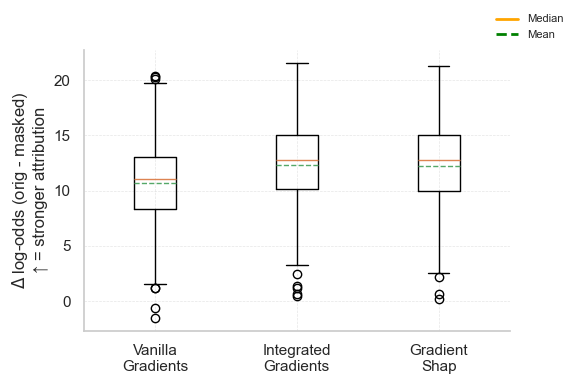

In [228]:
# Boxplot
fig, ax = plt.subplots(figsize=(6,4))
ax.boxplot([results[l] for l in labels],
           tick_labels=labels, showmeans=True, meanline=True)
median_line = plt.Line2D([0],[0], color='orange', linewidth=2)
mean_line   = plt.Line2D([0],[0], color='green', linestyle='--', linewidth=2)
ax.legend([median_line, mean_line],
          ['Median', 'Mean'], loc='lower right',
          fontsize=8, frameon=False, bbox_to_anchor=(1.15, 1.0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel(r"$\Delta$ log-odds (orig - masked)"+"\n↑ = stronger attribution")
ax.grid(linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()

### Plot pixel-wise attribution distributions

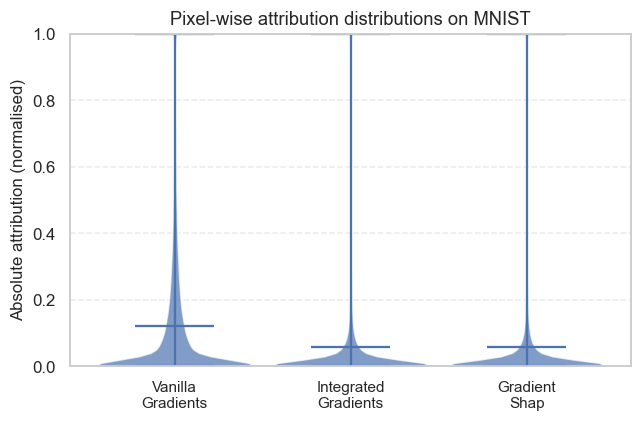

In [236]:
methods_plot = ["vanilla", "ig", "shap"]
labels_plot  = ["Vanilla\nGradients", "Integrated\nGradients", "Gradient\nShap"]

# 1) collect absolute attributions (no torch.no_grad so vanilla grads can flow)
raw_attr = {lab: [] for lab in labels_plot}

for img in eval_imgs:  # eval_imgs created in Panel B
    img = img.unsqueeze(0).to(device)
    tgt = model(img).argmax(1).item()
    for m, lab in zip(methods_plot, labels_plot):
        a = compute_attribution(m, model, img, target=tgt)
        raw_attr[lab].extend(torch.abs(a).flatten().cpu().numpy())

# 2) compute each method’s 99th percentile and normalise
import numpy as np
norm_attr = {}
for lab in labels_plot:
    arr   = np.array(raw_attr[lab])
    scale = np.percentile(arr, 99)
    norm_attr[lab] = np.clip(arr / (scale if scale > 0 else 1.0), 0, 1)

# 3) violin plot on shared [0,1] scale
fig, ax = plt.subplots(figsize=(6, 4), dpi=110)
data  = [norm_attr[lab] for lab in labels_plot]
parts = ax.violinplot(data, showmeans=True, showextrema=True, widths=0.9)
for pc in parts['bodies']:
    pc.set_alpha(0.7)

ax.set_xticks(range(1, len(labels_plot) + 1))
ax.set_xticklabels(labels_plot, fontsize=10)
ax.set_ylabel("Absolute attribution (normalised)", fontsize=11)
ax.set_title("Pixel-wise attribution distributions on MNIST", fontsize=12)
ax.set_ylim(0, 1)
ax.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

---

## Quantitative evaluation

In [127]:
x_batch, y_batch = next(iter(test_loader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

# Create segmentation masks based on simple thresholding
with torch.no_grad():
    x_batch_cpu_squeezed = x_batch.cpu().squeeze(1)
    s_batch = (x_batch_cpu_squeezed > 0.0).float().unsqueeze(1).to(device)

In [128]:
# Evaluate metrics for each explanation method
subset = 10                                                   # <= test_loader batch size
x_batch_np = x_batch[:subset].cpu().numpy()                   # (N,1,28,28)
y_batch_np = y_batch[:subset].cpu().numpy()                   # (N,)
s_batch_np = s_batch[:subset].cpu().numpy().astype(np.uint8)  # (N,1,28,28)

print(x_batch_np.shape, s_batch_np.shape)

(10, 1, 28, 28) (10, 1, 28, 28)


Define qualitative metrics (based on [Quantus](https://arxiv.org/abs/2202.06861) framework)

In [129]:
methods = ["Gradient", "IntegratedGradients", "GradientShap"]

metrics = {
    "Complexity": quantus.Sparseness(             # ↑ better
        abs=True, 
        normalise=True, # was false
        return_aggregate=True, 
    ),
    "Faithfulness": quantus.PixelFlipping(        # ↓ better
        features_in_step=1,
        abs=True,
        normalise=True,                          
        perturb_func=quantus.perturb_func.baseline_replacement_by_indices,
        perturb_baseline='black',
        return_aggregate=True,
        return_auc_per_sample=True,
    ), 
    "Localisation": quantus.PointingGame(         # ↑ better
        #weighted=True,
        abs=True,
        normalise=True,
        return_aggregate=True,
    ),
    "Randomisation": quantus.RandomLogit(         # ↓ better
        num_classes=10,
        similarity_func=quantus.similarity_func.ssim,
        #similarity_func=quantus.similarity_func.cosine,
        abs=True, 
        normalise=False, # was True 
        return_aggregate=True, 
    ),
    "Robustness": quantus.LocalLipschitzEstimate( # ↓ better
        nr_samples=50,                            # Number of perturbation samples/instance
        abs=False,                                # set True - So that neg/pos attribs dont cancel
        normalise=True,                           # Each saliency map ~ comparable scale
        perturb_func=quantus.perturb_func.gaussian_noise,
        perturb_mean=0.0,                         # Centered noise
        perturb_std=0.1,                          # Small enough to stay 'local' on MNIST pixel intensities
        return_nan_when_prediction_changes=True,  # If the model prediction flips, ignore those perturbations
        return_aggregate=True,
    ),
}

### Main Evaluation Loop
- for each of the XAI attribution method, for the given batch of image samples, obtain the related quantitative metrics
> **Beware:** computationally intensive!

In [ ]:
# NOTE: make sure masks are boolean uint8 numpy shaped like x_batch
#s_batch_np = (s_batch > 0).detach().cpu().numpy().astype(np.uint8)

results = {m: {} for m in methods}

for method in methods:
    print(f"Computing {method} metrics...")
    for name, metric in metrics.items():
        print(f"--> {name}...")
        kwargs = dict(
            model=model,
            x_batch=x_batch_np,
            y_batch=y_batch_np,
            device=device,
            explain_func=quantus.explain,
            explain_func_kwargs={"method": method},
        )
        if name == "Localisation": # RRA needs the masks
            kwargs["s_batch"] = s_batch_np
        score = metric(**kwargs)
        results[method][name] = float(score if np.isscalar(score) else score[0])
        torch.cuda.empty_cache()

Computing Gradient metrics...
--> Complexity...
--> Faithfulness...


c:\Users\simon\Desktop\dp\code\learning\quantus\venv\lib\site-packages\captum\attr\_core\saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
c:\Users\simon\Desktop\dp\code\learning\quantus\venv\lib\site-packages\quantus\helpers\warn.py:257: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(


--> Localisation...
--> Randomisation...
--> Robustness...
Computing IntegratedGradients metrics...
--> Complexity...
--> Faithfulness...
--> Localisation...
--> Randomisation...
--> Robustness...
Computing GradientShap metrics...
--> Complexity...
--> Faithfulness...
--> Localisation...
--> Randomisation...
--> Robustness...


### Preprocess the obtained results
Before plotting the results (radar plot), dataframes are created, and data is processed with:
- aggregation
- scaling
- ranking 

In [131]:
# Aggregate scores across metrics
results_agg = {method: {} for method in methods}
for method in methods:
    for metric in metrics:
        results_agg[method][metric] = np.mean(results[method][metric])

# Create dataframe and normalize values
df = pd.DataFrame.from_dict(results_agg).T.abs()

# if lower is better, use inverse ranking
lower_better = ["Robustness", "Faithfulness", "Randomisation"]
df_normalised = pd.DataFrame(index=df.index)

for metric in df.columns:
    if metric in lower_better:
        # invert: smaller raw -> bigger normalized
        df_normalised[metric] = df[metric].min() / df[metric]
    else:
        # higher raw -> bigger normalized
        df_normalised[metric] = df[metric] / df[metric].max()


# Calculate ranks
df_normalised_rank = df_normalised.rank()
df_normalised_rank

,Complexity,Faithfulness,Localisation,Randomisation,Robustness
Gradient,1.0,1.0,1.0,3.0,1.0
IntegratedGradients,3.0,3.0,2.5,1.0,3.0
GradientShap,2.0,2.0,2.5,2.0,2.0


In [ ]:
import seaborn as sns

# Plotting configs
sns.set()
sns.set_style("whitegrid")
plt.rcParams['ytick.labelleft'] = True; plt.rcParams['xtick.labelbottom'] = True

In [ ]:
def plot_radar_chart(df, title="XAI Method Relative Comparison"):
    """Creates a radar chart comparing XAI methods across different metrics."""
    labels = list(df.columns)
    N = len(labels)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]
    
    spoke_labels = labels
    
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
    ordered_colors = ["#008080", "#FFA500", "#0000FF"] #, "#6e0b5d"]
    
    for i, method in enumerate(df.index):
        row_values = df.loc[method].values.tolist()
        row_values += row_values[:1]
        ax.plot(angles, row_values, label=method, linewidth=2, color=ordered_colors[i])
        ax.fill(angles, row_values, alpha=0.12, color=ordered_colors[i])
    
    ax.set_xticks(angles[:-1])
    ax.tick_params(axis='x')
    for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
        angle_deg = np.degrees(angle)
        if 90 < angle_deg < 270:
            label.set_horizontalalignment('right')
        else:
            label.set_horizontalalignment('left')
    
    ax.set_xticklabels(spoke_labels, fontsize=14)
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'], fontsize=10)
    ax.set_ylim(0, 1.05)
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12) 
    ax.spines['polar'].set_visible(False)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    #plt.savefig('figures/ex2a_mnist_xai_radar.pdf', format='pdf', bbox_inches="tight", dpi=300)
    return fig, ax

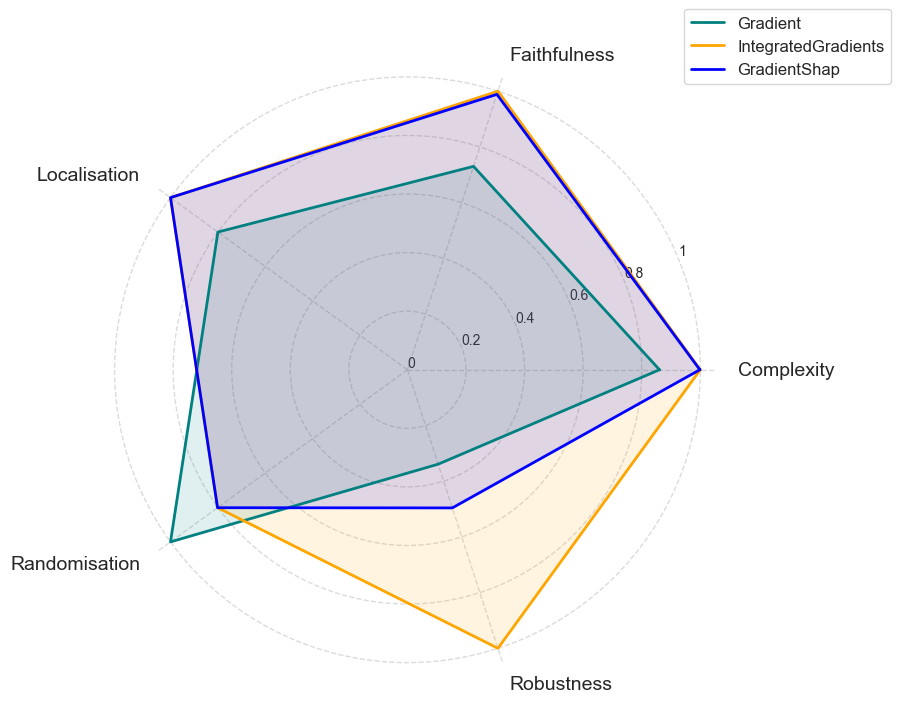

In [178]:
fig, ax = plot_radar_chart(df_normalised)
plt.show()

In [175]:
import matplotlib as mpl # handle pdf font
mpl.rcParams['pdf.fonttype'] = 42; mpl.rcParams['ps.fonttype']  = 42

In [ ]:
# Convert float values to integers
df_normalised_rank = df_normalised_rank.astype(int)

# map rank → radius : linear, centre stays at zero
def _rank_to_radius(df_rank: pd.DataFrame, radius_max: float = 0.8) -> pd.DataFrame:
    max_rank = df_rank.to_numpy().max()          # e.g. 3
    step = radius_max / max_rank                 # distance per rank level
    return df_rank * step

In [ ]:
def plot_radar_rank(
        df_rank: pd.DataFrame,
        title: str = "Rank-based radar plot",
        ordered_colors: list[str] | None = None,
        figsize: tuple[int, int] = (10, 8),
        radius_max: float = 0.8,
        save_path: str | None = None,
):
    """Create a radar plot showing rankings of different methods across metrics."""
    # -- radial data ---------------------------------------------------------
    df_radial = _rank_to_radius(df_rank, radius_max)

    # -- geometry ------------------------------------------------------------
    labels = list(df_rank.columns)
    N = len(labels)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1] # close polygon

    # -- colors ---------------------------------------------------------------
    ordered_colors = ["#008080", "#FFA500", "#0000FF"]

    # -- plot -----------------------------------------------------------------
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(polar=True))
    
    # -- outer-rank pentagon (max-rank outline + fill)
    outer = [radius_max] * N + [radius_max] # one radius per axis
    ax.fill(angles, outer, alpha=0.15, color="gray", zorder=0)

    ax.set_theta_zero_location('N')
    for i, method in enumerate(df_radial.index):
        vals = df_radial.loc[method].tolist() + df_radial.loc[method].tolist()[:1]
        ax.plot(angles, vals, linewidth=4, color=ordered_colors[i], label=method)
        ax.fill(angles, vals, alpha=0.12, color=ordered_colors[i])

    # -- axis labels + tick alignment -----------------------------------------
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=14)
    ax.tick_params(axis='x')

    # -- radial ticks: 0 (centre) ... max_rank (outer) ------------------------
    max_rank = df_rank.to_numpy().max()
    yticks = np.linspace(0, radius_max, max_rank + 1)      # include 0
    yticklabels = [str(r) for r in range(0, max_rank + 1)] # '0','1', ...,'3'
    ax.set_yticks(yticks)
    ax.set_yticklabels([])
    ax.set_ylim(0, radius_max)

    for lab in ax.get_xticklabels():
        lab.set_fontsize(16)
        if lab.get_text() in ("Faithfulness", "Robustness"):
            theta, r = lab.get_position()       # (angle [rad], radius)
            lab.set_position((theta, r - 0.1))  # push 0.08 'upwards'
            lab.set_verticalalignment('center')

    ax.grid(True, linestyle='-', alpha=0.7, color="white")
    ax.spines['polar'].set_visible(False)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12)

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    if save_path:
        fig.savefig(save_path, format='pdf', bbox_inches="tight", dpi=300)

    return fig, ax

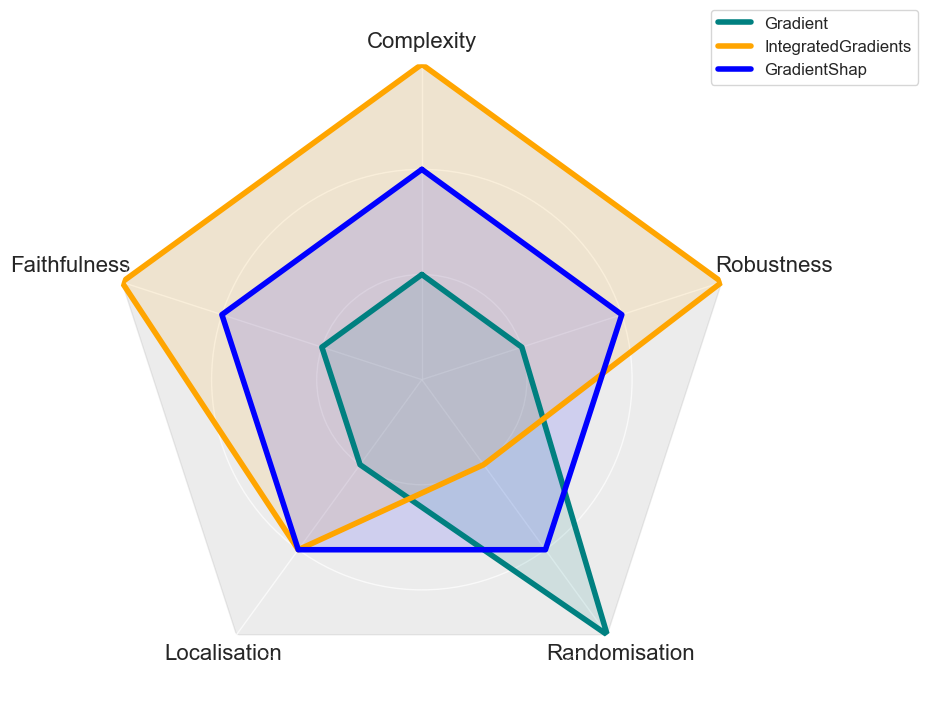

In [176]:
fig, ax = plot_radar_rank(df_normalised_rank)#, save_path="figures/ex2a_mnist_radar_ranked.pdf")
plt.show()
